# Import Libraries

In [2]:
import requests # to get the html markdown from the url
from bs4 import BeautifulSoup # to make the html readable
import pandas as pd # to save table in a csv
from datetime import datetime # to append current time into file name


# Get the data from website

In [3]:
url_surplus = 'https://web.byui.edu/SurplusList/'
html_data = requests.get(url_surplus)
soup = BeautifulSoup(html_data.text, 'html.parser')


# Build Table

In [4]:
rows=[]
for item in soup.find_all('tr')[13:]:
    row={}
    row['Item Number'] = item.select('td')[0].text
    row['Qty'] = item.select('td')[1].text
    row['Description'] = item.select('td')[2].text
    row['Condition'] = item.select('td')[3].text
    row['Price'] = item.select('td')[4].text
    row['Location'] = item.select('td')[5].text
    row['Quick/Bid'] = item.select('td')[6].text
    row['Image'] = item.select('td')[7].text
    rows.append(row)


In [150]:
data = pd.DataFrame(rows)
data

,Item Number,Qty,Description,Condition,Price,Location,Quick/Bid,Image
0,77056,1,"2013 27"" iMac",FAIR,$300.00,EA,Quick,
1,77047,1,"2017 Chevrolet Colorado ex cab 2wd, 2.5 auto e...",GOOD,"$21,995.00",EA,Bid,
2,75298,1,22 Oz Stainless Steel Top Water Bottle (Blue/P...,GOOD,$0.50,EA,Quick,Image
3,75668,5,5' storage/file cabinet,GOOD,$5.00,EA,Quick,
4,73180,1,8-Pack Verbatim Brand Blank Logo CD-R CDR 80,POOR,$0.25,AMT,Quick,Image
...,...,...,...,...,...,...,...,...
146,74385,1,Urban Expressions Gold Crossbody Bag,GOOD,$0.50,EA,Quick,Image
147,52769,59,VGA Cables,GOOD,$1.00,EA,Quick,Image
148,74697,1,White Neewer 2.4 GHz Wireless Remote in box or...,EXCELLENT,$1.25,EA,Quick,Image
149,75306,1,Zeroxposur Jacket for Man Size XXL (Black),GOOD,$1.75,EA,Quick,Image


## Save to CSV 

In [6]:
date = datetime.now().strftime("%d-%m-%Y %H%M%S") # get local time as string

filePath = "../Surplus - Historical Data/SurplusSaleItems " + date + " - Webscrape.csv"

data.to_csv(filePath, index=False) # save to file path

## Simple Data Analysis 

In [116]:
import matplotlib.pyplot as plt

In [151]:
data.drop(data.tail(1).index,inplace=True) # Drop last row (is empty)
data.describe()

,Item Number,Qty,Description,Condition,Price,Location,Quick/Bid,Image
count,150,150,150,150,150,150,150,150
unique,150,19,123,6,43,4,2,2
top,74778,1,Cisco 6500 series chassis,GOOD,$50.00,EA,Quick,Image
freq,1,123,28,112,33,116,143,95


In [152]:
# Change column data types
data.Price = pd.to_numeric(data.Price.str.replace("$","",regex=True).replace(",","",regex=True))
data['Item Number'] = pd.to_numeric(data['Item Number'])
data.Qty = pd.to_numeric(data.Qty)

# repeat rows based on quantity
data = data.reindex(data.index.repeat(data.Qty)).reset_index().drop(['index','Qty'], axis=1)

GOOD         2607
VARIES        535
EXCELLENT     104
FAIR           89
POOR            3
UNKNOWN         3
Name: Condition, dtype: int64

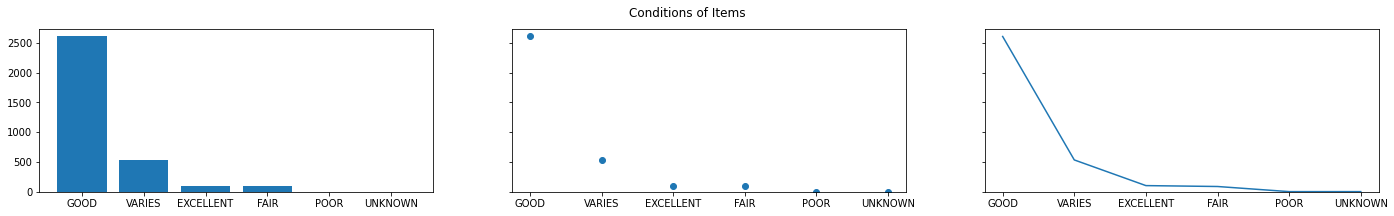

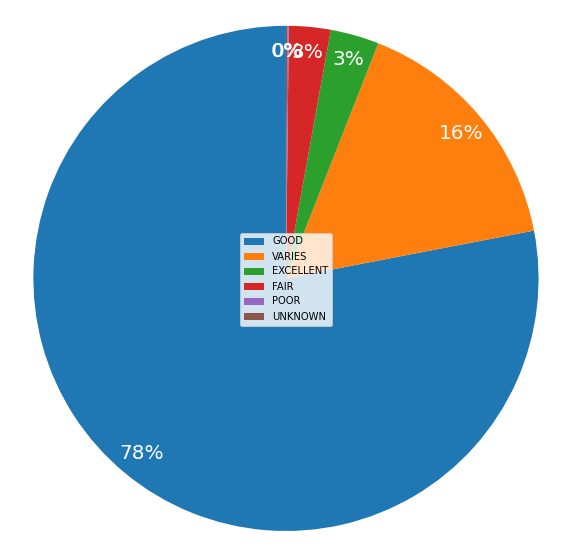

In [282]:
names = data['Condition'].value_counts().reset_index()['index']
values = data['Condition'].value_counts().reset_index()['Condition']

fig, axs = plt.subplots(1, 3, figsize=(24, 3), sharey=True)
axs[0].bar(names, values)
axs[1].scatter(names, values)
axs[2].plot(names, values)
fig.suptitle('Conditions of Items')

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(values, autopct='%1.0f%%', startangle=90,textprops={'color':"w",'fontsize': 20},pctdistance=0.9)
ax1.axis('equal')
plt.legend(names, loc="center")

data['Condition'].value_counts()

In [208]:
# Top 10 expensive items - overall

data.sort_values('Price',ascending=False).head(10)[['Description','Price','Condition']].reset_index().drop('index',axis=1)

,Description,Price,Condition
0,"2017 Chevrolet Colorado ex cab 2wd, 2.5 auto e...",21995.00,GOOD
1,"Electrolux Professional Ag, Ch-6210 Sursee Til...",17500.00,GOOD
2,Dakota turf tender 440,16000.00,EXCELLENT
3,Morgana Digifold Pro Folding/Scoring Machine,7500.00,FAIR
4,Gray Wheel lift model wl30,3495.00,EXCELLENT
5,Electric Pie Press with extras,3000.00,GOOD
6,Ice Dispenser,768.75,GOOD
7,BKI Free Standing Fry Dump Station or Food Wa...,700.00,GOOD
8,Sports O Zone Machine,500.00,GOOD
9,Labconco Paramount Filtered Enclosure stand,500.00,EXCELLENT


In [210]:
# Bottom 10 cheapest items - overall

data.sort_values('Price',ascending=False).tail(10)[['Description','Price','Condition']].reset_index().drop('index',axis=1)

,Description,Price,Condition
0,Black Sunglasses,0.50,GOOD
1,Black Sunglasses,0.50,GOOD
2,Black Cat-eye Sunglasses,0.50,GOOD
3,Aviator Sunglasses,0.50,GOOD
4,22 Oz Stainless Steel Top Water Bottle (Blue/P...,0.50,GOOD
5,Urban Expressions Gold Crossbody Bag,0.50,GOOD
6,8-Pack Verbatim Brand Blank Logo CD-R CDR 80,0.25,POOR
7,Square Large Earings,0.25,GOOD
8,Silver Ring with Stars Around It Size 10,0.25,GOOD
9,Stars golden bracelet,0.12,GOOD


In [237]:
# Top 10 highest price items - with Excellent condition

print('Top 10 highest price items - with Excellent condition')

data[
    (~data.Description.duplicated()) & # remove duplicates
    (data.Condition == 'EXCELLENT') # filter by condition = Excellent
].sort_values('Price',ascending=False).head(10)[ # top 10
    ['Description','Price','Condition'] # select columns 
].reset_index().drop('index',axis=1) # reset index

Top 10 highest price items - with Excellent condition


,Description,Price,Condition
0,Dakota turf tender 440,16000.00,EXCELLENT
1,Gray Wheel lift model wl30,3495.00,EXCELLENT
2,Labconco Paramount Filtered Enclosure stand,500.00,EXCELLENT
3,Sold by the case furnace filters,8.00,EXCELLENT
4,OIC 2 unit stackable Wall File System,3.00,EXCELLENT
5,Book The Good Guide by Alison L Grinder,1.25,EXCELLENT
6,White Neewer 2.4 GHz Wireless Remote in box or...,1.25,EXCELLENT
7,"Coin Boxes - Pennies, Nickels, Dimes",0.75,EXCELLENT


In [234]:
# Top 10 higest price items - with Good condition

print('Top 10 higest price items - with \'Good\' condition \n')

data[
    (~data.Description.duplicated()) & # remove duplicates
    (data.Condition == 'GOOD') # filter by condition = Excellent
].sort_values('Price',ascending=False).head(10)[ # top 10
    ['Description','Price','Condition'] # select columns 
].reset_index().drop('index',axis=1) # reset index


Top 10 higest price items - with 'Good' condition 



,Description,Price,Condition
0,"2017 Chevrolet Colorado ex cab 2wd, 2.5 auto e...",21995.00,GOOD
1,"Electrolux Professional Ag, Ch-6210 Sursee Til...",17500.00,GOOD
2,Electric Pie Press with extras,3000.00,GOOD
3,Ice Dispenser,768.75,GOOD
4,BKI Free Standing Fry Dump Station or Food Wa...,700.00,GOOD
5,Sports O Zone Machine,500.00,GOOD
6,Duke Tray Warmer,243.75,GOOD
7,Dual Drawer Toast Master,180.00,GOOD
8,Chick-fil-A Sandwich and Fry Display,121.25,GOOD
9,Fry Catch Basin,118.75,GOOD
